In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

#### Funcion de calibracion

In [3]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y':y
    })
    
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False)+1
    grouped = df_calibracion.groupby('bins').mean()
    
    plt.plot(grouped.predicciones, grouped.y, label='Modelo', marker = 'o')
    plt.plot(grouped.predicciones, grouped.predicciones, label='Real', marker = 'o')
    plt.grid()
    plt.legend()
    plt.xlabel('Prediccion')
    plt.ylabel('Real')

## Datos

In [4]:
df = pd.read_csv('Boston.csv')
df = df.drop(columns = ['Unnamed: 0'])
target = 'medv'
y = df[target]

## Modelo examen: Regresion polinomial grado 2 con feature engineering

In [5]:
df['dis_log'] = np.log(df['dis'])
df['age2'] = df['age'] ** 2
df['rm2'] = df['rm'] ** 2
df['nox_log'] = np.log(df['nox'])

df["tax_per_dis"] = (df["tax"] / df["dis"])
df["rm_per_lstat"] = (df["rm"] / df["lstat"])**2
df['nox_age'] = (df['nox'] * df['age'])**2
df['age_rm'] = (df['age'] / df['rm'])**2

In [6]:
X=df.copy()
X = X.drop(target, axis=1)

degree = 2

# Aplicar StandardScaler
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Crossvalidation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.3, random_state=42)

# Ridge o Lasso
model=linear_model.Ridge().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_poly2s = model.predict(X_test)
r2_score(y_pred = predicciones_poly2s, y_true=y_test)

0.9087027201030282

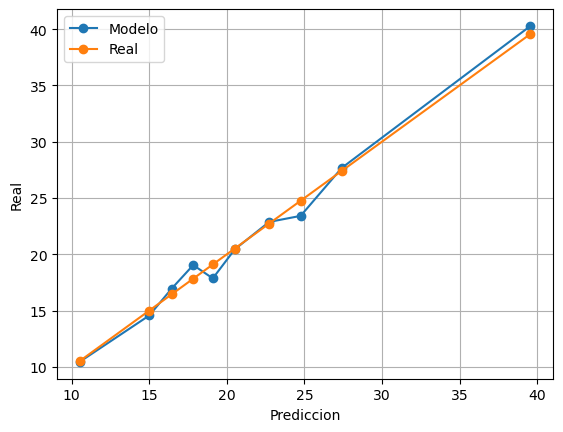

In [7]:
calibracion(predicciones_poly2s, y_test, 10)

#### Resultados

Para el examen, el mejor modelo que logré obtener fue uno con regresion polonomial grado 2 aplicando feature engineering agregando 8 variables nuevas. Con esto logré un R2 de 0.9087, lo cual es una regresión bastante buena que predice con gran exactitud. Como se ve en la gráfica de calibración, el modelo se ajusta bien a la tendencia lineal que siguen los datos, mostrando que es un modelo bueno para poder predecir.

## Random Forest

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
pipeline = Pipeline([
    ('rf', RandomForestRegressor(n_estimators=200, n_jobs=-1))
])

params = { 
    'rf__max_depth': [ 5,10, 25, 35,40,  50],
    'rf__max_features':['log2', 'sq rt', 0.5, 0.7, 10, 15, 25]
}

rf_grid = GridSearchCV(estimator=pipeline, n_jobs=-1, cv=5, scoring='r2', param_grid=params)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestRegressor(n_estimators=200,
                                                              n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [5, 10, 25, 35, 40, 50],
                         'rf__max_features': ['log2', 'sq rt', 0.5, 0.7, 10, 15,
                                              25]},
             scoring='r2')

In [19]:
rf_grid.best_params_

{'rf__max_depth': 35, 'rf__max_features': 'log2'}

In [18]:
best_model = rf_grid.best_estimator_.named_steps['rf']
predicciones_rf = best_model.predict(X_test)
r2_score(y_pred = predicciones_rf, y_true = y_test)

0.8793590830466229

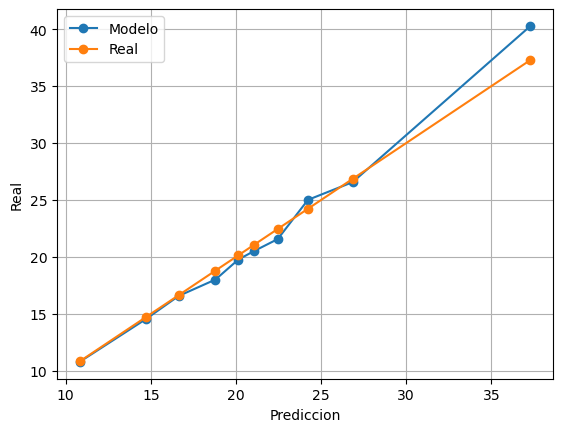

In [20]:
calibracion(predicciones_rf, y_test, 10)

#### Resultados

Con el Random forest decidimos intentar tanto con diferentes niveles de profundidad como el numero de variables que se tomaran en cada corte, y con estas poder llegar a le mejor resultado. En este caso el mejor de todos fue si hacemos un arbol con 35 cortes de profundidad y usamos el log2 para la parte de features, de esta forma obtenemos el mayor r2 que fue de 0.8793, logrando un gran ajuste a la varibilidad que tienen los datos.

## Conclusión

Tras haber realizado un modelo con regresion polinomial grado 2 usando feature engineering y hacer un árbol de decisión para el mismo Dataset, obtuvimos resultados muy interesantes. Mientras que para el modelo de Regresion polinomial obtuvimos un r2 de 0.90, para el random forest obtuvimos 0.8793, siendo una diferencia no muy grande, pero que en realidad, bajo ciertas circunstancias puede llegar a ser muy determinante. Teniendo esto en cuenta, se puede decir que es un mejor modelo el de regresion polinomial que el que se logró con random forest. 

A pesar de esta diferencia, se puede ver que para nada el random forest es un mal modelo, de hecho en las graficas de calibración se puede ver que ambas se ajustan muy bien a los datos, aunque si existen unas diferencias notables entre las dos. Mientras que a la regresión polinomial le cuesta ajustarse un poco más en la parte de la mitad de los datos y a los costados esta muy bien ajustada, a la de random forest el inicio esta muy bien y a la mitad de los datos le empieza a costar ajustarse más, muy parecido a la de la regresión polinomial. Sin embargo, para el final tiene un desajuste más importante, haciendo que el r2 tenga esa baja importante que lo lleva a ser peor modelo que el otro.

En conclusión, se puede decir que ambos modelos son buenos ya que se ajustan muy bien a la variabilidad que se presentan en los datos y tendrán un buen rendimiento a la hora de hacer predicciones, aunque al esperar minimizarse el error a la hora de predecir, la regresión polinomial grado 2 es el mejor modelo.